# 🔄 Building the ReAct Agent Pattern from Scratch in AI Agents
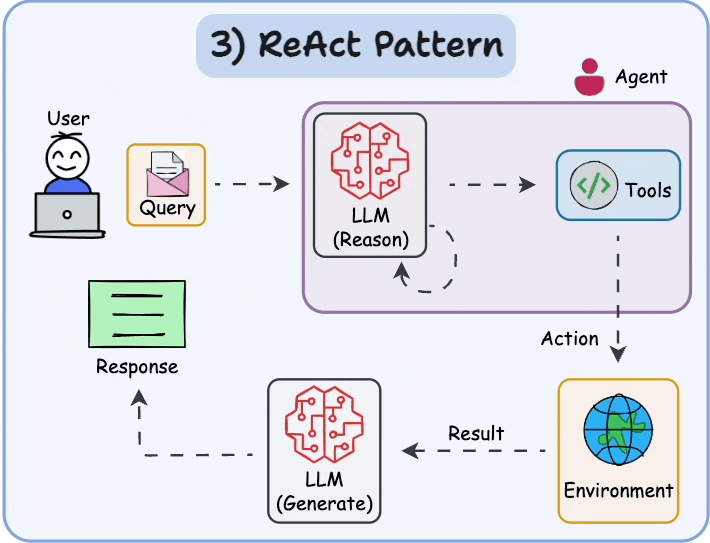
This notebook dives into the ReAct Pattern—short for Reasoning + Acting—a foundational architecture for AI agents introduced in the paper ReAct: Synergizing Reasoning and Acting in Language Models by Yao et al. In this pattern, an agent alternates between thinking (reasoning) and taking actions, allowing it to solve complex tasks interactively while maintaining internal transparency and traceability.

Unlike static prompting, the ReAct approach enables agents to generate thoughts, invoke tools or actions, observe outcomes, and reflect in a structured loop. It serves as the backbone of many modern agents, including LangChain, LangGraph, and AutoGPT.

## 🧠 What You'll Learn:
#### How to build a ReAct agent loop from scratch
#### How to model thoughts, actions, and observations as part of agent behavio
#### How ReAct improves performance on reasoning-heavy or tool-requiring tasks



In [ ]:
import re
import json
from src.decorator import tool # this is a wrapper function that turn the function into a tool object (look the code in decoretor.py file)

# Uploade the LLM API

In [ ]:
from Utils.utils import llm

# create  functions (tools)

these functions are the tools that llm could use to generate a better awnser.
the doc string of each function should be very describable of the function purpose and its arguments for llm to understand it and call it with right argument.

In [ ]:
@tool
def calculate_phynx_factor(a: int, b: int) -> int:
    """
    Compute the 'phynx factor' for two integer inputs.

    The phynx factor is defined as the square of the product of `a` and `b`.
    Mathematically: phynx_factor = (a * b)²

    """
    print(f"--- TOOL: Calculating phynx factor for {a} and {b} ---")
    return (a * b) ** 2


@tool
def xex_factor(a:int , b:int) -> float:
    """
    Compute the 'xex factor' for two integer inputs.

    The xex factor is defined as the square of the product of `a` and `b`.
    Mathematically: xexf actor = (a + b) / 20

    Parameters:
        a (int): The first input integer.
        b (int): The second input integer.

    Returns:
        int: The computed xex factor.
    """
    print(f"--- TOOL: Calculating xex factor for {a} and {b} ---")
    
    return (a + b) / 20


## Creating the system prmpt

In [48]:
chat_history =[]

system_prompt =  """
You are a function calling AI model. You operate by running a loop with the following steps: Thought, Action, Observation.
You are provided with function signatures within <tools></tools> XML tags.
You may call one or more functions to assist with the user query. Don' make assumptions about what values to plug
into functions. Pay special attention to the properties 'types'. You should use those types as in a Python dict.

For each function call return a json object with function name and arguments within <tool_call></tool_call> XML tags as follows:

<tool_call>
{"name": <function-name>,"arguments": <args-dict>, "id": <monotonically-increasing-id>}
</tool_call>

Here are the available tools / actions:

<tools> 
%5
</tools>

Example session:

<question>What's the current temperature in Madrid?</question>
<thought>I need to get the current weather in Madrid</thought>
<tool_call>{"name": "get_current_weather","arguments": {"location": "Madrid", "unit": "celsius"}, "id": 0}</tool_call>

You will be called again with this:

<observation>{0: {"temperature": 25, "unit": "celsius"}}</observation>

You then output:

<response>The current temperature in Madrid is 25 degrees Celsius</response>

Additional constraints:

- If the user asks you something unrelated to any of the tools above, answer freely enclosing your answer with <response></response> tags.
"""

# construct_the tools


In [ ]:
llm_tools = {
    'calculate_phynx_factor' : calculate_phynx_factor,
    'xex_factor' : xex_factor
}

In [50]:
#add tools into the system prompt
llm_tools_object = str(llm_tools['calculate_phynx_factor'].func_information) + ',\n' + str(llm_tools['xex_factor'].func_information)
system_prompt = system_prompt.replace('%5',llm_tools_object)
chat_history.append(
    {
        'role' : 'system',
        'content' : system_prompt
    }
)

In [51]:
chat_history

[{'role': 'system',
  'content': '\nYou are a function calling AI model. You operate by running a loop with the following steps: Thought, Action, Observation.\nYou are provided with function signatures within <tools></tools> XML tags.\nYou may call one or more functions to assist with the user query. Don\' make assumptions about what values to plug\ninto functions. Pay special attention to the properties \'types\'. You should use those types as in a Python dict.\n\nFor each function call return a json object with function name and arguments within <tool_call></tool_call> XML tags as follows:\n\n<tool_call>\n{"name": <function-name>,"arguments": <args-dict>, "id": <monotonically-increasing-id>}\n</tool_call>\n\nHere are the available tools / actions:\n\n<tools> \n{\'name\': \'calculate_phynx_factor\', \'description\': "\\nCompute the \'phynx factor\' for two integer inputs.\\n\\nThe phynx factor is defined as the square of the product of `a` and `b`.\\nMathematically: phynx_factor = (a 

## get the LLM Taught Procces

the LLM will procces the query and give his taught on the problem and the tool calls

In [52]:
user_prompt = 'what is the result of 1 and 50 using the phynx factor?'
chat_history.append(
    {
        'role' : 'user',
        'content' : user_prompt
    }
)

llm_responce = llm(str(chat_history))
chat_history.append(
        {
        'role' : 'assistant',
        'content' : llm_responce
    }
)


In [53]:
llm_responce

'<thought>I need to use the calculate_phynx_factor tool to compute the phynx factor of 1 and 50.</thought>\n<tool_call>\n{"name": "calculate_phynx_factor", "arguments": {"a": 1, "b": 50}, "id": 0}\n</tool_call>\n'

## Return the tool name and its argument as a string

In [ ]:
#create a function that take what between the tool tags and turn it into json


def extract_tool_calls(text):
    pattern = r"<tool_call>(.*?)</tool_call>"
    return re.findall(pattern, text, re.DOTALL)

[{'name': 'calculate_phynx_factor', 'arguments': {'a': 1, 'b': 50}, 'id': 0}]

In [ ]:
llm_tool_calls = [json.loads(c) for c in extract_tool_calls(llm_responce)]
llm_tool_calls

## run the tools functions

In [55]:
#call the tools
for t in llm_tool_calls:
    result = llm_tools[t['name']].run(**t['arguments']) 
    #append as an observation 
    chat_history.append(
        {
            'role':'system',
            'content' : f'<observation>{result}</observation>'
        }
    ) 


--- TOOL: Calculating phynx factor for 1 and 50 ---


## LLM response

after the observation proccces the llm will consider the tool result and awnser the query

In [56]:
#rerun the thaught proces 
llm_responce_2 = llm(str(chat_history))

In [59]:
llm_responce_2

'<response>The phynx factor of 1 and 50 is 2500.</response>'